>[Анализ поведения пользователей мобильного приложения <***>](#scrollTo=4sHsM5E6lB0d)

>>[Общая информация.](#scrollTo=rkh1bYNHlB0g)

>>[Предобработка данных](#scrollTo=8XtyFXZolB0i)

>>[Анализ данных](#scrollTo=w-iI8n49lB0m)

>>[Построение воронки событий](#scrollTo=TtntupAAlB0u)

>>[Анализ результатов A/B теста](#scrollTo=r5qud7j5lB0w)

>>[Вывод](#scrollTo=Leam83salB05)



# Анализ поведения пользователей мобильного приложения <***>

В нашем распоряжении имеются логи пользователей мобильного приложения <***>.  

**Цель исследования**
 * нахождение слабых мест воронки событийной
 * оценка A/B теста по изменению шрифта приложения

**Оцениваемые параметры**:  

* конверсия переходов между этапами воронки
* разница конверсий между тестовой и контрольной группами


**План исследования**:  

* составление воронки событий
* проведение A/B-теста
* анализ результатов
  * сравнение показателей контрольных групп
  * сравнение показателей контрольных и тестовых групп

In [65]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from scipy import stats as st
import math as mth
from plotly import graph_objects as go
import warnings
pd.set_option('precision', 2)


In [66]:
#загрузим данные
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

## Общая информация.

In [67]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В таблице `hypothesis` четыре столбца.  
Столбец `EventTimestamp` нужно преобразовать к формату дат. Остальное верно

Согласно документации к данным:  

* `EventName` — название события
* `DeviceIDHash` — уникальный идентификатор пользователя
* `EventTimestamp` — время события
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

## Предобработка данных

In [69]:
# приведем к корректному виду названия столбцов

data = data.rename(columns={'EventName':'event_name','DeviceIDHash': 'user_id','EventTimestamp':'event_time','ExpId':'expr_id'})

In [70]:
#проверим пропуски
print(data.isna().sum())

event_name    0
user_id       0
event_time    0
expr_id       0
dtype: int64


пропусков нет

In [71]:
# проверим нулевые значения
for i in data.columns.tolist():
    print(i,len(data[data[i]==0]))

event_name 0
user_id 0
event_time 0
expr_id 0


нулевых значений нет

In [72]:
#проверим дубликаты
display(data[data.duplicated()])

,event_name,user_id,event_time,expr_id
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [73]:
print('Обруружено', len(data[data.duplicated()]), 'повторяющихся строк из', len(
                        data), ',что составляет:{:.2f}% датасета'.format(len(data[data.duplicated()])*100/len(data)))

Обруружено 413 повторяющихся строк из 244126 ,что составляет:0.17% датасета


Удалим их

In [74]:
data = data.drop_duplicates().reset_index(drop=True)

In [75]:
# преобазуем столбец с датами в формат даты
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

# добавим столбец с датой без времени
data['event_date'] = data['event_time'].dt.normalize()


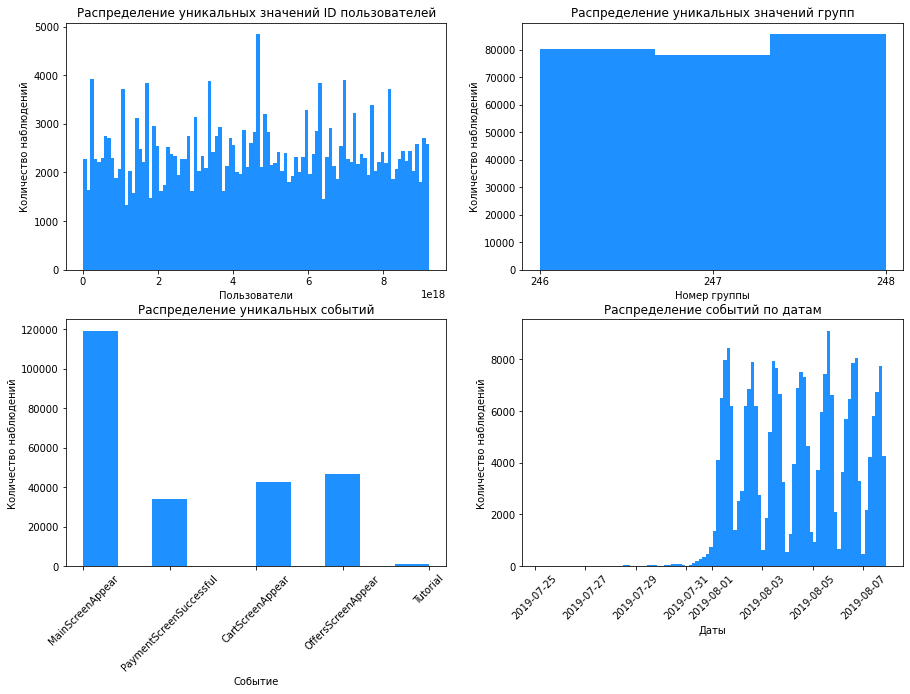

In [76]:
# проверим распределения количеств значений в таблице
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 2, 1)
data['user_id'].hist(bins=100, color='dodgerblue', grid = False)
plt.xlabel('Пользователи')
plt.ylabel('Количество наблюдений')
plt.title('Распределение уникальных значений ID пользователей')
ax2 = plt.subplot(2, 2, 2)
data['expr_id'].hist(bins=3, color='dodgerblue', grid = False)
plt.xlabel('Номер группы')
plt.ylabel('Количество наблюдений')
plt.xticks(data['expr_id'].unique())
plt.title('Распределение уникальных значений групп')
ax3 = plt.subplot(2, 2, 3)
data['event_name'].hist(bins=10, color='dodgerblue', grid = False)
plt.xlabel('Событие')
plt.ylabel('Количество наблюдений')
plt.title('Распределение уникальных событий')
plt.xticks(rotation=45)
ax4 = plt.subplot(2, 2, 4)
data['event_time'].sort_values().hist(bins=100, color='dodgerblue', grid = False)
plt.xlabel('Даты')
plt.ylabel('Количество наблюдений')
plt.title('Распределение событий по датам')
plt.xticks(rotation=45);

 * Записи идентификаторов пользователя распределяются в целом равномерно, есть отдельные пики, посмотрим далее подробно  
 * Количество наблюдений по группам на одном уровне
 * Событие `MainScreenAppear` самое популярное, встречается более чем в 2 раза чем другие, событие `Tutorial` самое редкое  
 * Есть выбивающиеся даты, основной диапазон с 01 августа, но есть отдельные наблюдения раннего периода

In [77]:
#посчитаем пользователей, которые оказались в обеих группах
check = data.groupby('user_id', as_index=False).agg({'expr_id' : 'nunique'})
print('Количество пересекающихся пользователей в обеих группах:',
            len(check[check['expr_id']>1]), 'из', data['user_id'].nunique ())
print('Доля пересекающихся пользователей в обеих группах: {:.2f}%'.format(
            len(check[check['expr_id']>1])*100/data['user_id'].nunique ()))

Количество пересекающихся пользователей в обеих группах: 0 из 7551
Доля пересекающихся пользователей в обеих группах: 0.00%


**Некорректных значений в данных не обнаружено  
Пропусков не было  
Обнаружены дубликаты 0.17% строк  
Присутствуют даты не соответсвующие большинству значений, изучим подробнее далее  
Пересечений пользователей по группам нет**

## Анализ данных

Изучим данные подробнее

In [78]:
data.nunique()

event_name         5
user_id         7551
event_time    176654
expr_id            3
event_date        14
dtype: int64

В логе:  
5 уникальных событий  
7551 пользователя  
3 группы  
14 дней

In [79]:
# общее количество событий
print('Общее количество событий:',len(data))

Общее количество событий: 243713


In [80]:
# посчитаем количество событий на пользователя
event_per_user = data.groupby('user_id', as_index=False)['event_name'].count()
event_per_user .columns = ['user_id', 'event_name_cnt']
display(event_per_user.sort_values(by = 'event_name_cnt',ascending=False))


,user_id,event_name_cnt
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221
...,...,...
6013,7399061063341528729,1
2356,2968164493349205501,1
6575,8071397669512236988,1
311,425817683219936619,1


In [81]:
print('Среднее количество событий на пользователя: {:.1f}'.format(event_per_user['event_name_cnt'].mean()))
print('Медианное количество событий на пользователя: {:.1f}'.format(event_per_user['event_name_cnt'].median()))

Среднее количество событий на пользователя: 32.3
Медианное количество событий на пользователя: 20.0


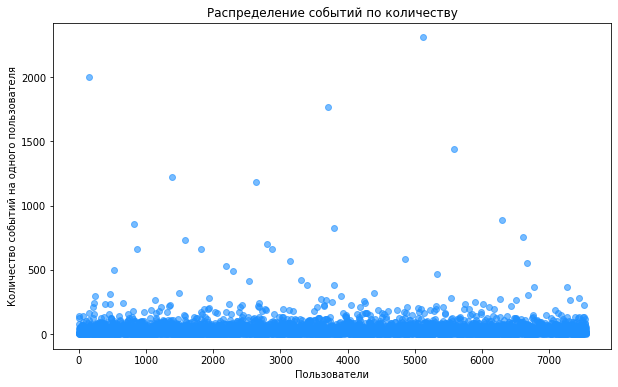

In [82]:
# посмотрим распределение по пользователям
x_values = pd.Series(range(0,len(event_per_user)))
plt.figure(figsize=(10, 6))
plt.scatter(x_values, event_per_user['event_name_cnt'], alpha=0.6, color='dodgerblue')
plt.xlabel('Пользователи')
plt.ylabel('Количество событий на одного пользователя')
plt.title('Распределение событий по количеству');

In [83]:
print('95 персентиль', np.percentile(event_per_user['event_name_cnt'], 95))
print('99 персентиль', np.percentile(event_per_user['event_name_cnt'], 99))

95 персентиль 89.0
99 персентиль 200.5


95% пользователей совершают 89 событий и менее  
99% пользователей совершают 200 событий и менее  

Уберем аномальных пользователей с числом событий более 89

In [84]:
usersWithManyEvents = event_per_user[
            event_per_user['event_name_cnt'] > np.percentile(event_per_user['event_name_cnt'], 99)]['user_id']
data_filt = data[np.logical_not(data['user_id'].isin(usersWithManyEvents))]

In [85]:
print('Доля удаленных пользователей с аномальными заказами: {:.2f}%'.format(100-
    data_filt['user_id'].nunique()*100/data['user_id'].nunique ()))
print('Доля удаленных событий пользователей с аномальными заказами: {:.2f}%'.format(100-
    data_filt['event_name'].count()*100/data['event_name'].count()))

Доля удаленных пользователей с аномальными заказами: 1.01%
Доля удаленных событий пользователей с аномальными заказами: 14.11%


In [86]:
print('После удаления аномальных пользователей среднее количество событий на пользователя: {:.1f}'.format(
                                                                                len(data_filt)/data_filt['user_id'].nunique()))

После удаления аномальных пользователей среднее количество событий на пользователя: 28.0


In [87]:
# проверим даты и посчитаем количество активных пользовталей и событий 
chek_date = data.groupby('event_date', as_index=False).agg({'user_id':'nunique','event_name':'count'})
chek_date['event/user'] = chek_date['event_name']/chek_date['user_id']
display(chek_date)


,event_date,user_id,event_name,event/user
0,2019-07-25,7,9,1.29
1,2019-07-26,22,31,1.41
2,2019-07-27,39,55,1.41
3,2019-07-28,69,105,1.52
4,2019-07-29,135,184,1.36
5,2019-07-30,296,412,1.39
6,2019-07-31,924,2030,2.20
7,2019-08-01,3703,36141,9.76
8,2019-08-02,3647,35554,9.75
9,2019-08-03,3482,33282,9.56


Количество событий и пользователей сопоставимы между собой в период с 1 по 7 августа  
События до 1 августа выглядят подозрительно.  
Гораздо меньше пользователей, меньше событий и соотношение событий к пользователю также выбивается из общего ряда  
Возможно это 'левые' события из прошлого.  
Взглянем еще раз на гистограмму частот записей по времени:

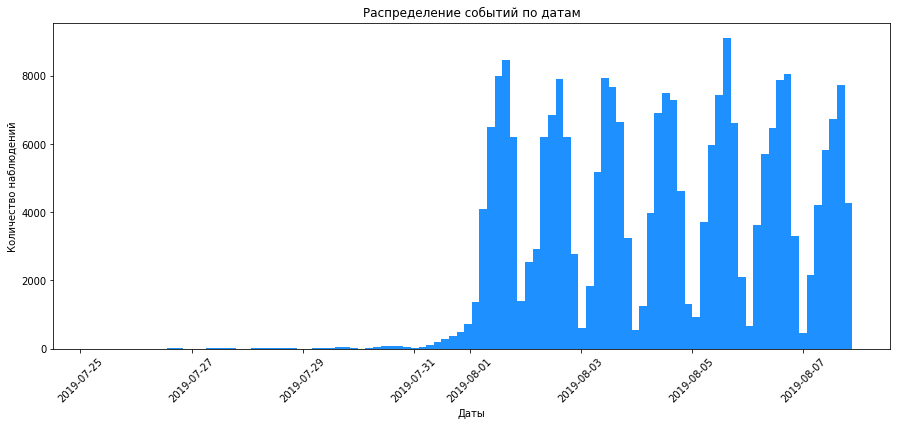

In [88]:
plt.figure(figsize=(15, 6))
data['event_time'].sort_values().hist(bins=100, color='dodgerblue', grid=False)
plt.xlabel('Даты')
plt.ylabel('Количество наблюдений')
plt.title('Распределение событий по датам')
plt.xticks(rotation=45);

Распределение событий ранее 01/08/19 выглядят иначе, придется удалить события меньше 01/08/2019

Посчитаем долю пользователей и событий на удаление:

In [89]:
print('Доля пользователей с аномальными датами: {:.2f}%'.format(
    len(data_filt[np.logical_not(data_filt['user_id'].isin(
        data_filt[data_filt['event_date']>='2019-08-01']['user_id']))]['user_id'].unique())*100/
                                                                                            data_filt['user_id'].nunique ()))
print('Доля событий с аномальными датами: {:.2f}%'.format(
    len(data_filt[data_filt['event_date']<'2019-08-01'])*100/data_filt['event_name'].count()))


Доля пользователей с аномальными датами: 0.23%
Доля событий с аномальными датами: 1.30%


In [90]:
# удалим события меньше 01/08/2019
data_filt = data_filt[data_filt['event_date']>='2019-08-01']

Посчитаем сколько всего мы удалили пользователей и событий с учетом аномальных заказов и аномальных дат:

In [91]:
print('Доля удаленных пользователей с аномальными заказами и аномальными датами: {:.2f}%'.format(100-
    data_filt['user_id'].nunique()*100/data['user_id'].nunique ()))
print('Доля удаленных событий пользователей с аномальными заказами и аномальными датами: {:.2f}%'.format(100-
    data_filt['event_name'].count()*100/data['event_name'].count()))

Доля удаленных пользователей с аномальными заказами и аномальными датами: 1.23%
Доля удаленных событий пользователей с аномальными заказами и аномальными датами: 15.22%


Проверим распределение пользователей по группам:

In [92]:
data_filt.groupby('expr_id').agg({'user_id' : 'nunique'})


,user_id
expr_id,
246,2456
247,2491
248,2511


Пользователи равномерно распределены по всем трем группам

Посмотрим на распределение событий по количеству в целом и по пользователям:

In [93]:
event = data_filt.groupby('event_name', as_index=False).agg({
                'expr_id':'count','user_id':'nunique'}).sort_values(by='user_id',ascending=False).reset_index(drop=True)
event.columns = [['event_name','event_name_cnt','user_id_cnt']]
event['share_of_total_user,%'] = event['user_id_cnt'] *100/data_filt['user_id'].nunique()
display(event)


,event_name,event_name_cnt,user_id_cnt,"share_of_total_user,%"
0,MainScreenAppear,113264,7344,98.47
1,OffersScreenAppear,40956,4517,60.57
2,CartScreenAppear,29250,3658,49.05
3,PaymentScreenSuccessful,22164,3463,46.43
4,Tutorial,981,824,11.05


Самое популярное событие(внезапно) - `MainScreenAppear`, встречается более, чем в 2 раза чаще остальных  
Событие `Tutorial` встречается редко, очевидно это необязательный пункт.  
По количеству уникальных пользователей на событие тенденция та же, больше всего пользователей совершили событие `MainScreenAppear`, меньше всего `Tutorial`  
Из всех пользователей только 98.5% совершили событие `MainScreenAppear`, что странно  
Половина пользователей дошла до корзины, чуть меньше смогло оплатить  
Только 11% проходило `Tutorial`

Посмотрим на пользователей, которые миновали главный экран.

In [94]:
main_scr_users = data_filt[data_filt['event_name']=='MainScreenAppear']['user_id']
not_main_scr_users = data_filt[np.logical_not(data_filt['user_id'].isin(main_scr_users))]
not_main_scr_users.groupby('event_name', as_index=False).agg({
                'expr_id':'count','user_id':'nunique'}).sort_values(by='user_id',ascending=False)

,event_name,expr_id,user_id
1,OffersScreenAppear,922,110
0,CartScreenAppear,804,98
2,PaymentScreenSuccessful,645,97
3,Tutorial,7,4


Выглядит так, что данные пользователи пришли в корзину через событие `OffersScreenAppear`  
Возможно, это были пуши или ссылки ведущие прямо на страницу выбора.  
Или это техническая ошибка и по этим пользователям пропала часть логов.  

Посмотрим на примере одного пользователя его лог

In [95]:
display(not_main_scr_users)

,event_name,user_id,event_time,expr_id,event_date
3221,PaymentScreenSuccessful,5322240575085479425,2019-08-01 01:55:25,246,2019-08-01
3222,CartScreenAppear,5322240575085479425,2019-08-01 01:55:25,246,2019-08-01
3255,OffersScreenAppear,3187166762535343300,2019-08-01 02:01:30,247,2019-08-01
3323,OffersScreenAppear,5322240575085479425,2019-08-01 02:15:50,246,2019-08-01
3332,OffersScreenAppear,5322240575085479425,2019-08-01 02:16:58,246,2019-08-01
...,...,...,...,...,...
240083,PaymentScreenSuccessful,3788810404193836212,2019-08-07 18:24:10,247,2019-08-07
240084,CartScreenAppear,3788810404193836212,2019-08-07 18:24:11,247,2019-08-07
240447,PaymentScreenSuccessful,2890852187923418999,2019-08-07 18:40:51,246,2019-08-07
240448,CartScreenAppear,2890852187923418999,2019-08-07 18:40:52,246,2019-08-07


In [96]:
data_filt[data_filt['user_id']==2890852187923418999].head(50)

,event_name,user_id,event_time,expr_id,event_date
151437,PaymentScreenSuccessful,2890852187923418999,2019-08-05 10:07:19,246,2019-08-05
151440,CartScreenAppear,2890852187923418999,2019-08-05 10:07:20,246,2019-08-05
151441,OffersScreenAppear,2890852187923418999,2019-08-05 10:07:22,246,2019-08-05
192906,OffersScreenAppear,2890852187923418999,2019-08-06 12:17:28,246,2019-08-06
192913,CartScreenAppear,2890852187923418999,2019-08-06 12:17:37,246,2019-08-06
192914,PaymentScreenSuccessful,2890852187923418999,2019-08-06 12:17:37,246,2019-08-06
193930,OffersScreenAppear,2890852187923418999,2019-08-06 12:52:26,246,2019-08-06
193963,OffersScreenAppear,2890852187923418999,2019-08-06 12:53:09,246,2019-08-06
193970,OffersScreenAppear,2890852187923418999,2019-08-06 12:53:24,246,2019-08-06
240447,PaymentScreenSuccessful,2890852187923418999,2019-08-07 18:40:51,246,2019-08-07


Видим, что шаги воронки непоследовательны.  
Посчитаем сколько таких пользователей и событий:

In [97]:
print('Доля пользователей без просмотра главного экрана: {:.2f}%'.format(
                            not_main_scr_users['user_id'].nunique()*100/data_filt['user_id'].nunique()))
print('Доля событий пользователей без просмотра главного экрана: {:.2f}%'.format(len(not_main_scr_users)*100/len(data_filt)))


Доля пользователей без просмотра главного экрана: 1.53%
Доля событий пользователей без просмотра главного экрана: 1.15%


Оставим эти данные

## Построение воронки событий

**Построим воронку событий:**  
Пользователи заходят в приложение - `MainScreenAppear`  
Выбирают товары - `OffersScreenAppear`  
Переходят в корзину - `CartScreenAppear`  
Оплачивают - `PaymentScreenSuccessful`  

Среди событий есть `Tutorial`, вероятно, данное событие не является обязательным и пользователи могут совершать его по желанию   
Судя по тому что его проходит лишь 11% пользователей, `Tutorial` не эффективен.

Построим воронку по шагам и посчитаем сколько пользователей проходит на следующий шаг воронки от предыдущего

In [98]:
funnel = data_filt[data_filt['event_name']!='Tutorial'].groupby('event_name').agg({
                'user_id':'nunique'}).sort_values(by='user_id',ascending=False)
funnel.columns = ['user_id_cnt']
funnel['share_of_total_user,%'] = funnel['user_id_cnt'] *100/data_filt['user_id'].nunique()
funnel['step_conversion,%'] = (funnel['user_id_cnt'].pct_change().fillna(0)+1)*100
display(funnel)

,user_id_cnt,"share_of_total_user,%","step_conversion,%"
event_name,,,
MainScreenAppear,7344,98.47,100.00
OffersScreenAppear,4517,60.57,61.51
CartScreenAppear,3658,49.05,80.98
PaymentScreenSuccessful,3463,46.43,94.67


Визуализируем воронку

In [99]:
# строим график
fig = go.Figure(go.Funnel(
    y = list(funnel.index.values),
    x = funnel['user_id_cnt'].tolist()))
fig.update_layout(title="Воронка событий")
fig.show()

Больше всего пользователей ~ 40% - теряется на этапе перехода на страницу с предложениями `OffersScreenAppear`  
Возможно, этот механизм перехода непонятен или неудобен.  
80% тех кто перешел на страницу выбора, переходит в корзину.  	
До оплаты доходит 46% пользователей от всех,что зашли в приложение

## Анализ результатов A/B теста

Проанализируем результаты A/B теста по изменению дизайна шрифтов  
Для теста мы разделили пользователей на  три группы  - две контрольных **246 и 247 - со старыми шрифтами** и одну тестовую **248 - с новыми**.  

Анализировать будем показатели доли пользователей каждого этапа приложения от общего количества пользователей 
Сначала сравним контрольные группы между собой, затем тестовую с каждой контрольной по отдельности и объединенной контрольной

Посмотрим как отличаются доли пользователей между группами

In [100]:
# посчитаем количество уникальных пользователей по группам и событиям воронки
data_pivot = data_filt.query('event_name !="Tutorial"').pivot_table(
    index='event_name', columns='expr_id',values='user_id',aggfunc='nunique').sort_values(by=246,ascending=False)
data_pivot['control'] = data_pivot[246]+data_pivot[247]
data_pivot['share_of_total_246,%'] = data_pivot[246]*100/data_filt[data_filt['expr_id']==246]['user_id'].nunique()
data_pivot['share_of_total_247,%'] = data_pivot[247]*100/data_filt[data_filt['expr_id']==247]['user_id'].nunique()
data_pivot['share_of_total_248,%'] = data_pivot[248]*100/data_filt[data_filt['expr_id']==248]['user_id'].nunique()
data_pivot['share_of_total_control,%'] = data_pivot['control']*100/(
        data_filt[data_filt['expr_id']==246]['user_id'].nunique()+data_filt[data_filt['expr_id']==247]['user_id'].nunique())
display(data_pivot)


expr_id,246,247,248,control,"share_of_total_246,%","share_of_total_247,%","share_of_total_248,%","share_of_total_control,%"
event_name,,,,,,,,
MainScreenAppear,2423,2454,2467,4877,98.66,98.51,98.25,98.59
OffersScreenAppear,1514,1498,1505,3012,61.64,60.14,59.94,60.89
CartScreenAppear,1238,1216,1204,2454,50.41,48.82,47.95,49.61
PaymentScreenSuccessful,1172,1136,1155,2308,47.72,45.60,46.00,46.65


Показатели тестовой группы немного хуже, чем контрольных  
Посмотрим? является ли эта разница статистически значимой

Подготовим данные

In [101]:
# переведем значения каждого этапа в массивы 
MainScreen = data_pivot.iloc[0,0:4].to_numpy()
OffersScreen = data_pivot.iloc[1,0:4].to_numpy()
CartScreen = data_pivot.iloc[2,0:4].to_numpy()
PaymentScreen = data_pivot.iloc[3,0:4].to_numpy()



In [102]:
# общее количество уникальных пользователей
groups = data_filt.groupby('expr_id').agg({'user_id' : 'nunique'})
# посчитаем объединенную группу
groups.loc['control'] = groups.loc[246, 'user_id'] + groups.loc[247, 'user_id']
total = groups['user_id'].to_numpy()

In [103]:
data_filt.groupby('expr_id').agg({'user_id' : 'nunique'})

,user_id
expr_id,
246,2456
247,2491
248,2511


In [104]:
display(MainScreen)
display(OffersScreen)
display(CartScreen)
display(PaymentScreen)
display(total)



array([2423., 2454., 2467., 4877.])

array([1514., 1498., 1505., 3012.])

array([1238., 1216., 1204., 2454.])

array([1172., 1136., 1155., 2308.])

array([2456, 2491, 2511, 4947])

Нам необходимо проверить гипотезу о равенстве средних долей. Для этого проведем z-тест  
Напишем функцию для проверки:

In [105]:
def equal_proportion (part, total, group1, group2, alpha):
    alpha = alpha
    # пропорция успехов в первой группе:
    p1 = part[group1]/total[group1]

    # пропорция успехов во второй группе:
    p2 = part[group2]/total[group2]

    # пропорция успехов в комбинированном датасете:
    p_combined = (part[group1] + part[group2]) / (total[group1] + total[group2])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total[group1] + 1/total[group2]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    
    print('alpha: {:.4f}'.format (alpha))
    print('Разница тест - контроль: {:.4f}'.format (p2 - p1))
    print('p-значение: {:.4f}'.format ( p_value))
    

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
         print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
            
    return p_value
    
    

**Проверим разницу в численности контрольных групп для теста:**
    

In [106]:
print('Разница между контрольными группами: {:.2f}%'.format (abs (total[0]*100/total[1]-100)))

Разница между контрольными группами: 1.41%


Разница ~ 1%, группы подходят для A/A теста

**Проверим есть ли значимые отличия в результатах контрольных групп**

Гипотезы.  
H0 - различий в доле уникальных посетителей MainScreen от общего числа пользователей между контрольными группами нет.  
H1 - различия в доле уникальных посетителей MainScreen от общего числа пользователей между контрольными группами есть.

In [107]:
result1 = equal_proportion (MainScreen, total, 0, 1, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0014
p-значение: 0.6731
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей OffersScreen от общего числа пользователей между контрольными группами нет.  
H1 - различия в доле уникальных посетителей OffersScreen от общего числа пользователей между контрольными группами есть.

In [108]:
result2 = equal_proportion (OffersScreen, total, 0, 1, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0151
p-значение: 0.2770
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей CartScreen от общего числа пользователей между контрольными группами нет.  
H1 - различия в доле уникальных посетителей CartScreen от общего числа пользователей между контрольными группами есть.

In [109]:
result3 = equal_proportion (CartScreen, total, 0, 1,0.05)

alpha: 0.0500
Разница тест - контроль: -0.0159
p-значение: 0.2630
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей PaymentScreen от общего числа пользователей между контрольными группами нет.  
H1 - различия в доле уникальных посетителей PaymentScreen от общего числа пользователей между контрольными группами есть.

In [110]:
result4 =equal_proportion (PaymentScreen,total, 0, 1, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0212
p-значение: 0.1359
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Статистически значимых отличий ни на одном этапе воронки между контрольными группами не обнаружено  
Разбиение на группы работает корректно**

**Проверим есть ли значимые отличия в результатах тестовой и контрольных групп**

**Контрольная группа 246**

Гипотезы.  
H0 - различий в доле уникальных посетителей MainScreen от общего числа пользователей между тестовой и контрольной группой 246 нет.  
H1 - различия в доле уникальных посетителей MainScreen от общего числа пользователей между тестовой и контрольной группой 246 есть.

In [111]:
result5 = equal_proportion (MainScreen, total, 0, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0041
p-значение: 0.2438
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей OffersScreen от общего числа пользователей между тестовой и контрольной группой 246 нет.  
H1 - различия в доле уникальных посетителей OffersScreen от общего числа пользователей между тестовой и контрольной группой 246 есть.

In [112]:
result6 = equal_proportion (OffersScreen, total, 0, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0171
p-значение: 0.2175
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей CartScreen от общего числа пользователей между тестовой и контрольной группой 246 нет.  
H1 - различия в доле уникальных посетителей CartScreen от общего числа пользователей между тестовой и контрольной группой 246 есть.

In [113]:
result7 = equal_proportion (CartScreen, total, 0, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0246
p-значение: 0.0832
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей PaymentScreen от общего числа пользователей между тестовой и контрольной группой 246 нет.  
H1 - различия в доле уникальных посетителей PaymentScreen от общего числа пользователей между тестовой и контрольной группой 246 есть.

In [114]:
result8 = equal_proportion (PaymentScreen,total, 0, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0172
p-значение: 0.2239
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Контрольная группа 247**

Гипотезы.  
H0 - различий в доле уникальных посетителей MainScreen от общего числа пользователей между тестовой и контрольной группой 247 нет.  
H1 - различия в доле уникальных посетителей MainScreen от общего числа пользователей между тестовой и контрольной группой 247 есть.

In [115]:
result9 = equal_proportion (MainScreen, total, 1, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0027
p-значение: 0.4545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей OffersScreen от общего числа пользователей между тестовой и контрольной группой 247 нет.  
H1 - различия в доле уникальных посетителей OffersScreen от общего числа пользователей между тестовой и контрольной группой 247 есть.

In [116]:
result10 = equal_proportion (OffersScreen, total, 1, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0020
p-значение: 0.8851
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей CartScreen от общего числа пользователей между тестовой и контрольной группой 247 нет.  
H1 - различия в доле уникальных посетителей CartScreen от общего числа пользователей между тестовой и контрольной группой 247 есть.

In [117]:
result11 = equal_proportion (CartScreen, total, 1, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0087
p-значение: 0.5397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей PaymentScreen от общего числа пользователей между тестовой и контрольной группой 247 нет.  
H1 - различия в доле уникальных посетителей PaymentScreen от общего числа пользователей между тестовой и контрольной группой 247 есть.

In [118]:
result12 = equal_proportion (PaymentScreen,total, 1, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: 0.0039
p-значение: 0.7801
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Объединенная контрольная группа**

Гипотезы.  
H0 - различий в доле уникальных посетителей MainScreen от общего числа пользователей между тестовой и общей контрольной группой нет.  
H1 - различия в доле уникальных посетителей MainScreen от общего числа пользователей между тестовой и общей контрольной группой есть.

In [119]:
result13 = equal_proportion (MainScreen, total, 3, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0034
p-значение: 0.2619
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей OffersScreen от общего числа пользователей между тестовой и общей контрольной группой нет.  
H1 - различия в доле уникальных посетителей OffersScreen от общего числа пользователей между тестовой и общей контрольной группой есть.

In [120]:
result14 = equal_proportion (OffersScreen, total, 3, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0095
p-значение: 0.4280
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей CartScreen от общего числа пользователей между тестовой и общей контрольной группой нет.  
H1 - различия в доле уникальных посетителей CartScreen от общего числа пользователей между тестовой и общей контрольной группой есть.

In [121]:
result15 = equal_proportion (CartScreen, total, 3, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0166
p-значение: 0.1762
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотезы.  
H0 - различий в доле уникальных посетителей PaymentScreen от общего числа пользователей между тестовой и общей контрольной группой нет.  
H1 - различия в доле уникальных посетителей PaymentScreen от общего числа пользователей между тестовой и общей контрольной группой есть.

In [122]:
result16 = equal_proportion (PaymentScreen,total, 3, 2, 0.05)

alpha: 0.0500
Разница тест - контроль: -0.0066
p-значение: 0.5909
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Поправка на множественные сравнения**

Так как в нашем тесте более, чем две группы и несколько сравнений, увеличивается вероятность получить ошибку первого рода(найти разницу там где ее нет)  
Необходимо скорректировать уровень значимости  
Всего мы провели 4 сравнения для 4 вариантов экрана, итого 16 сравнений  
Поправка Бонферрони не очень приемлимый вариант, тк значительно снизит мощность теста  

Воспользуемся методом Холма 

Для этого нам нужно упорядочить наши гипотезы по возрастанию p1, ..., p16 и самое низкое значение p_value сравнить с самым низким уровнем значимости = 0.05/количество сравнений  
Если p1 > alpha/16 => принимаем все гипотезы p1, ..., p16 и останавливаемся.  
Иначе продолжаем проверку, сравниваем  p2 и alpha/15, если p2 > alpha/15 => принимаем все гипотезы p2, ..., p16 и останавливаемся и т.д.  
Для последнего сравнения уровень значимости = 0.05/1


In [123]:
# сгененируем последовательность скорректированных yровней значимости
alpha = []
for m in [i for i in range(16, 0, -1)]:
    alpha.append(0.05/m)
display(alpha)    

[0.003125,
 0.0033333333333333335,
 0.0035714285714285718,
 0.0038461538461538464,
 0.004166666666666667,
 0.004545454545454546,
 0.005,
 0.005555555555555556,
 0.00625,
 0.0071428571428571435,
 0.008333333333333333,
 0.01,
 0.0125,
 0.016666666666666666,
 0.025,
 0.05]

In [124]:
#объединим все p_value
all_p_values = result1, result2,result3,result4,result5,result6,result7,result8,result9,result10,result11,result12,result13,result14,result15,result16

In [125]:
display(all_p_values)

(0.6730951807208485,
 0.27702771700769824,
 0.26299626637167783,
 0.13586258367273985,
 0.24380010740478975,
 0.21751867407994285,
 0.08317408116828573,
 0.2239322340682175,
 0.4545336230756303,
 0.8850746269495819,
 0.539679592997024,
 0.7800603242138475,
 0.26186402859555846,
 0.42801834712141273,
 0.17619153820927536,
 0.5908710902173984)

In [126]:
#создадим датафрейм из p_value и добавим номер гипотезы
data = {'number_of_hyp': range(1,17), 'p_value': all_p_values}
check_hyp = pd.DataFrame(data)
#отсортируем от самого низкого значения p_value
check_hyp.sort_values(by = 'p_value',inplace=True, ignore_index=True)
#добавим скорректированные alpha
check_hyp['alpha'] = alpha
#добавим столбец с проверкой, если p_value больше alpha, то Истина
check_hyp['p_value_more_alpha'] = np.where(check_hyp['p_value']>= check_hyp['alpha'], True, False)
display(check_hyp)

,number_of_hyp,p_value,alpha,p_value_more_alpha
0,7,0.08,3.13e-03,True
1,4,0.14,3.33e-03,True
2,15,0.18,3.57e-03,True
3,6,0.22,3.85e-03,True
4,8,0.22,4.17e-03,True
5,5,0.24,4.55e-03,True
6,13,0.26,5.00e-03,True
7,3,0.26,5.56e-03,True
8,2,0.28,6.25e-03,True
9,14,0.43,7.14e-03,True


Останаваливаем проверку гипотез на первом этапе и принимаем все нулевые гипотезы, так как самое низкое p_value значение больше минимального уровня значимости  
**Статистически значимых различий между долями посетителей каждого уровня экрана среди тестовых и контрольных групп не обнаружно**

Также стоит отметить, что в нашем эксперименте мы получили слишком высокие значения p-value, чтобы отклонить хотя бы одну нулевую гипотезу даже при уровне значимости скорректированном методом Бонферрони

## Вывод
       

В ходе исследования были изучены логи пользователей мобильного приложения <***>   

После предварительной обработки данных были обнаружены дубликаты - 0.17% от общего числа строк - были удалены  
Некорректных значений и пропусков не было  
В логах содержались данные с 2019-07-25 по 2019-08-07  
Для анализа мы взяли период с 2019-08-01 по 2019-08-07, тк данные до 2019-08-01 были единичными, предположительно хвосты прошлых периодов  
Пересечений пользователей между группами обнаружено не было  

В анализируемом периоде пользователь в среднем совершает 28 событий, медианное значение 20 событий на пользователя  
1% пользователей совершает более 200 событий, поэтому мы удалили их из анализа.  
Таким образом, всего в датафрейме было удалено:
 * 1.2% пользователей
 * 15.2% строк (событий)

**Анализ воронки:**  

Последовательность шагов  
 * Основной экран - `MainScreenAppear`  
 * Страница выбора товаров - `OffersScreenAppear`  
 * Корзина - `CartScreenAppear`  
 * Успешная оплата - `PaymentScreenSuccessful`  

На этап выбора товаров переходит 60% пользователей, из них на этап оплаты переходит 80%, до успешной оплаты доходит 95% пользователей  
В конечном итоге заказ оформиляет 46% пользователей от общего числа.

Проблемные места воронки:
 * переход `MainScreenAppear` → `OffersScreenAppear`, теряем **40%** пользователей  
**Рекомендации** - проверить механизм перехода, возможно он непонятен или неудобен. Проверить интрфейс главной страницы, он должен быть привелекательным и не отпугивать пользователей. 
 
 * переход `OffersScreenAppear` → `CartScreenAppear`, теряем **20%** пользователей от предыдущего уровня  
**Рекомендации** - проверить насколько информативны и юзерфрендли карточки товара. Проверить процесс добавления товара в корзину - должен быть очевиден и удобен. Проверить насколько конкурентоспособны цены.   
 
 * переход `CartScreenAppear` → `PaymentScreenSuccessful`, **5%** пользователей не доходят до оплаты  
**Рекомендации** - проверить отсутствие технических неполадок, можно сравнить эти данные показателями прошлого периода. Если это стабильный уровень конверсии, можно применить методы для возврата покупателя к корзине - напоминания. Проверить насколько прост и удобен механизм оплаты.  

 
**Анализ A/B теста по изменения дизайна шрифта:**  
Для теста мы разделили пользователей на три группы, две контрольные 246 и 247 - со старыми шрифтами и одна тестовая 248 - с новыми и сравнили конверсии каждого уровня воронки от общего количества пользователей в группе  
Для каждого уровня воронки было проведено 4 сравнения - между контрольными группами, между тестовой и каждой контольной в отдельности и тестовой и объединенной контрольной, итого 16 сравнений.   
По результатам теста статистически значимых различий между показателями конверсии каждого этапа воронки среди тестовых и контрольных групп не обнаружно не было  
Таким образом, смена шрифта не приведет ни к ухудшению ни к улучшению показателей конверсии на любом этапе воронки, конверсия в покупку при в обоих случаях на уровне 46%  
Для увеличения показателей воронки нужно проверять каждый этап отдельно и искать проблемные места. Общие рекомендации были даны чуть выше.
 
